In [1]:
import numpy as np
import matplotlib.pyplot as plt
import deepxde as dde 
from analytical import sound_hard_circle


#dde.config.set_default_float('float64')
#dde.config.set_default_float('float64')
dde.config.set_default_float('float32')


'''                        Problem parameters                               '''
k0 = 1          # wavenumber
# 5 is fine!
# 8 is more or less ok. ¿Add more points?
# Added more points, but not really ok with just 20.000 iterations + BFGS
# Change the learning rate? 
# Avec8 et 15 points, learning rate = 0.05, n'arrive pas a apprendre l'interieur...

wave_len = 2*np.pi / k0  # wavelength

dim_x = 2 * np.pi
n_wave = 10

# The mesh element size is h_elem
h_elem = wave_len / n_wave

nx = int(dim_x / h_elem)
print(h_elem, 'h_elem')
print( nx, 'nx')
print(nx **2, 'nx**2')

Using backend: tensorflow.compat.v1

2021-10-29 07:05:28.583718: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


Instructions for updating:
non-resource variables are not supported in the long term

Set the default float type to float32
0.6283185307179586 h_elem
10 nx
100 nx**2


Compiling model...
Building feed-forward neural network...
'build' took 0.044625 s



/opt/conda/envs/DL/lib/python3.9/site-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/opt/conda/envs/DL/lib/python3.9/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1692: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
2021-10-29 07:05:30.298154: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-10-29 07:05:30.379261: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: Quadro RTX 8000 computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 47.46GiB deviceMemoryBandwidth: 625.94GiB/s
2021-10-29 07:

'compile' took 0.799895 s

Initializing variables...
Training model...

Step      Train loss                                  Test loss                                   Test metric   
0         [3.34e-01, 1.19e-01, 4.48e+01, 2.28e+02]    [3.43e-01, 1.19e-01, 4.48e+01, 2.28e+02]    [1.25e+00]    


2021-10-29 07:05:31.080805: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3000205000 Hz


1000      [4.00e-02, 5.55e-02, 5.94e-03, 1.80e-02]    [4.40e-02, 5.66e-02, 5.94e-03, 1.80e-02]    [4.10e-01]    
2000      [1.16e-02, 1.42e-02, 1.84e-03, 9.74e-04]    [1.10e-02, 1.36e-02, 1.84e-03, 9.74e-04]    [2.24e-01]    
3000      [2.56e-03, 3.44e-03, 4.42e-03, 7.24e-03]    [2.41e-03, 3.11e-03, 4.42e-03, 7.24e-03]    [1.05e-01]    
4000      [1.23e-03, 1.03e-03, 8.96e-03, 4.55e-02]    [9.67e-04, 8.83e-04, 8.96e-03, 4.55e-02]    [5.78e-02]    
5000      [4.90e-04, 4.60e-04, 4.90e-03, 1.56e-03]    [4.00e-04, 4.27e-04, 4.90e-03, 1.56e-03]    [2.83e-02]    
6000      [3.35e-04, 2.69e-04, 3.24e-05, 7.02e-05]    [2.74e-04, 2.65e-04, 3.24e-05, 7.02e-05]    [1.70e-02]    
7000      [2.84e-04, 2.14e-04, 8.07e-04, 1.40e-03]    [2.23e-04, 2.32e-04, 8.07e-04, 1.40e-03]    [1.57e-02]    
8000      [2.36e-04, 1.67e-04, 2.27e-05, 3.95e-05]    [1.86e-04, 1.92e-04, 2.27e-05, 3.95e-05]    [1.27e-02]    
9000      [2.10e-04, 1.39e-04, 1.61e-04, 3.82e-05]    [1.61e-04, 1.68e-04, 1.61e-04, 3.82e-05]  

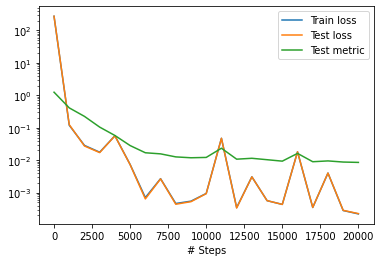

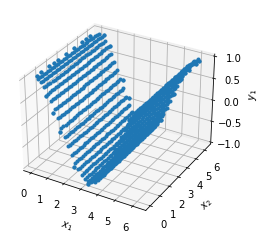

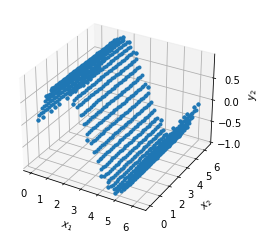

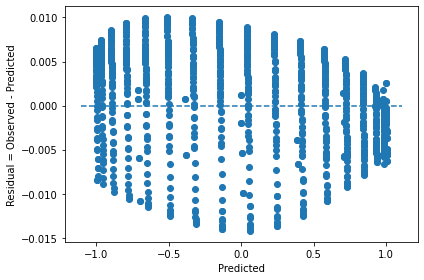

In [2]:
geom = dde.geometry.Rectangle([0, 0], [dim_x, dim_x])

def pde(x, y):
    y0, y1 = y[:, 0:1], y[:, 1:2]
    
    y0_xx = dde.grad.hessian(y, x, component=0, i=0, j=0)
    y0_yy = dde.grad.hessian(y, x, component=0, i=1, j=1)

    y1_xx = dde.grad.hessian(y, x,component=1, i=0, j=0)
    y1_yy = dde.grad.hessian(y, x,component=1, i=1, j=1)

    return [-y0_xx - y0_yy - k0 ** 2 * y0,
            -y1_xx - y1_yy - k0 ** 2 * y1]

def sol(x):
    return np.exp(1j * k0 * x[:, 0:1])

def boundary(_, on_boundary):
    return on_boundary

def func0(x, y):
    normal = geom.boundary_normal(x)
    g0 = np.real(1j * k0 * np.exp(1j * k0 * x[:, 0:1]) * (normal[:, 0:1]-1))
    
    return g0 - k0 * y[:, 1:2]

def func1(x, y):
    normal = geom.boundary_normal(x)
    g1 = np.imag(1j * k0 * np.exp(1j * k0 * x[:, 0:1]) * (normal[:, 0:1]-1))
    return g1 + k0 * y[:, 0:1]

bc0 = dde.RobinBC(geom, func0, boundary, component = 0)
bc1 = dde.RobinBC(geom, func1, boundary, component = 1)

def func(x):
    real = np.real(np.exp(1j * k0 * x[:, 0:1]))
    imag = np.imag(np.exp(1j * k0 * x[:, 0:1]))
    return np.hstack((real, imag))

bcs = [bc0, bc1]
weights = [1, 1, 100, 100]

data = dde.data.PDE(geom, pde, bcs, num_domain= nx**2, num_boundary= 4 * nx, num_test= 10 * nx ** 2, solution = func)
net = dde.maps.FNN([2] + [50] * 4 + [2], "tanh", "Glorot uniform")
model = dde.Model(data, net)

model.compile("adam", lr=0.001, loss_weights= weights, metrics=["l2 relative error"])
losshistory, train_state = model.train(epochs=20000)

dde.saveplot(losshistory, train_state, issave=True, isplot=True)

#model.compile("L-BFGS")
#losshistory, train_state = model.train()

Relative error =  0.008408201072696398


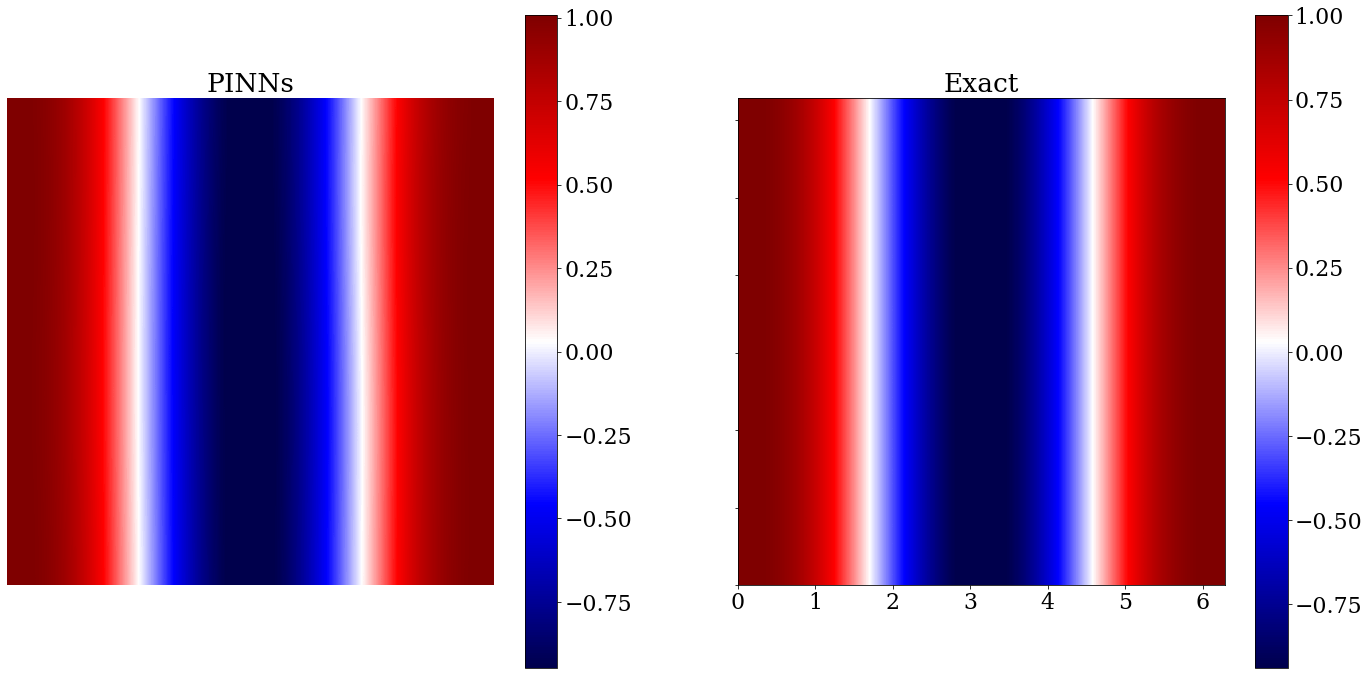

In [3]:

'''            Evaluate field over a specified grid of points              '''
# Square grid with 10 points per wavelength in each direction
Nx = int(np.ceil(dim_x/wave_len * 10))
Ny = Nx


# Grid points
xmin, xmax, ymin, ymax = [0, dim_x, 0, dim_x]
plot_grid = np.mgrid[xmin:xmax:Nx * 1j, ymin:ymax:Ny * 1j]
points = np.vstack((plot_grid[0].ravel(),
                    plot_grid[1].ravel(),
                    np.zeros(plot_grid[0].size)))

points_2d = points[:2, :]

#in_circ = points[0, :]**2 + points[1, :]**2 <= (radius)**2
#in_circ_2d = points_2d[0, :]**2 + points_2d[1, :]**2 <= (radius)**2
#points[0, in_circ] = -radius - wave_len / 10
#points[1, in_circ] = radius + wave_len / 10
#points[2, in_circ] = 0.

# Bounding box tree etc for function evaluations

u_sca = model.predict(points[:2, :].T)
u_sca = u_sca[:, 0] + 1j* u_sca[:, 1]
u_sca = u_sca.reshape((Nx, Ny))

'''                  Compare against analytical solution                    '''
# Uncomment to perform comparison, takes a few seconds to run

u_exact = sol(points.T)
u_exact = u_exact.reshape((Nx, Ny))
diff = u_exact-u_sca
error = np.linalg.norm(diff)/np.linalg.norm(u_exact)
print('Relative error = ', error)

'''                     Plot field and save figure                          '''
plt.rc('font', family='serif', size=22)

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize = (24,12))

pcm = ax1.imshow(np.fliplr(np.real(u_sca)).T,
           extent=[0,dim_x,0,dim_x],
           cmap=plt.cm.get_cmap('seismic'), interpolation='spline16', label='PINN')

ax1.axis('off')
fig.colorbar(pcm, ax = ax1)

pcm = ax2.imshow(np.fliplr(np.real(u_exact)).T,
           extent=[0,dim_x,0,dim_x],
           cmap=plt.cm.get_cmap('seismic'), interpolation='spline16', label = 'Exact')


#ax1.axis('off')
ax1.set_title('PINNs')
ax2.set_title('Exact')
fig.colorbar(pcm, ax = ax2)


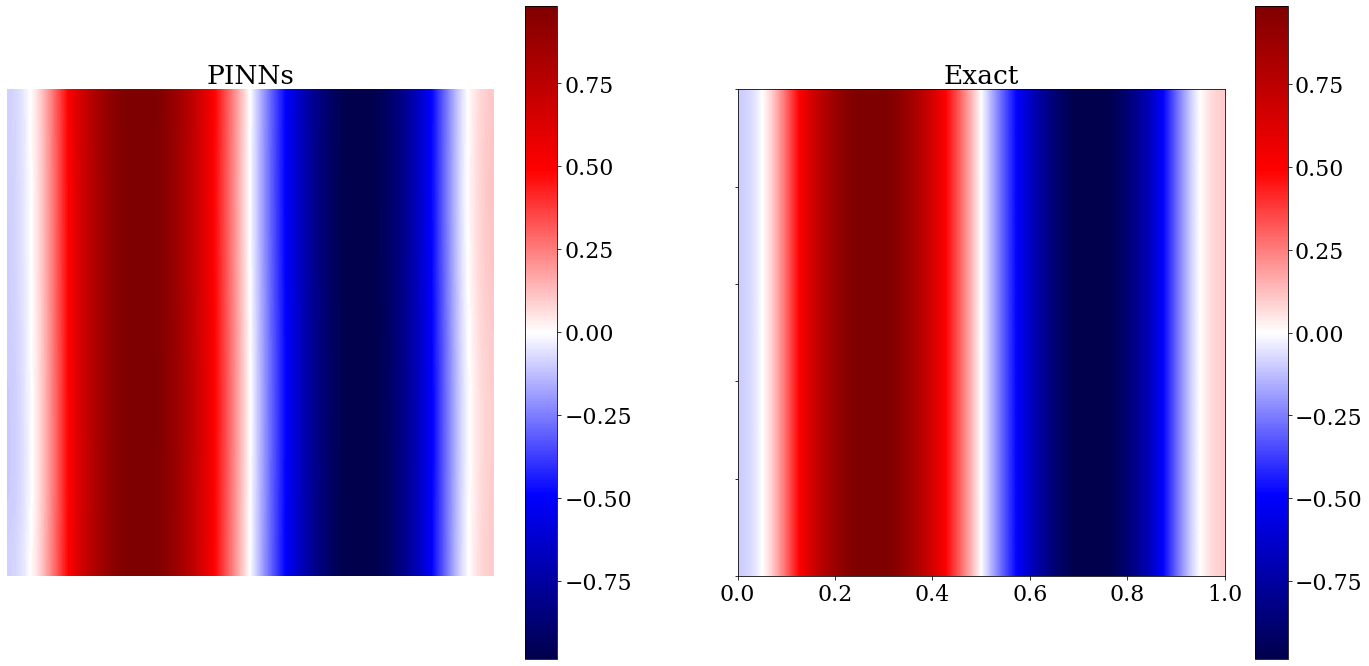

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize = (24,12))

pcm = ax1.imshow(np.fliplr(np.imag(u_sca)).T,
           extent=[0,1,0,1],
           cmap=plt.cm.get_cmap('seismic'), interpolation='spline16', label='PINN')


ax1.axis('off')
fig.colorbar(pcm, ax = ax1)

pcm = ax2.imshow(np.fliplr(np.imag(u_exact)).T,
           extent=[0,1,0,1],
           cmap=plt.cm.get_cmap('seismic'), interpolation='spline16', label = 'Exact')

ax1.axis('off')
ax1.set_title('PINNs')
ax2.set_title('Exact')
fig.colorbar(pcm, ax = ax2)


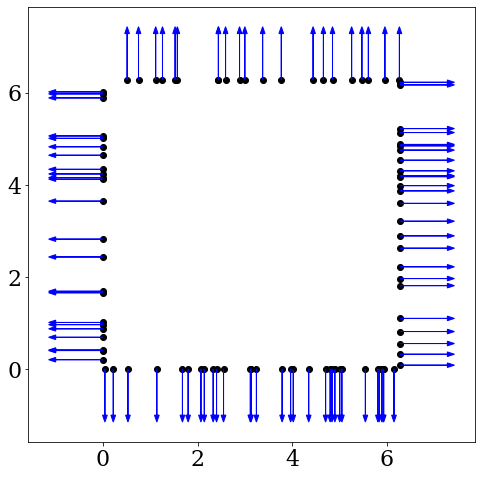

In [6]:
x = geom.random_boundary_points(100)
normal = geom.boundary_normal(x)

fig = plt.figure(figsize = (8,8))
plt.scatter(x[:,0], x[:,1], color = 'k')
npts = x.shape[0]
for i in range(npts):
    plt.arrow(x[i,0], x[i,1], normal[i,0], normal[i,1], color = 'b', head_width = .1)